In [1]:
import os
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import Window
from rasterio.merge import merge
from rasterio import features
from matplotlib import pyplot as plt
import geopandas as gpd
import glob
import sys
import re
import pandas as pd
import netCDF4
from datetime import datetime
from sklearn.preprocessing import scale
from scipy.interpolate import UnivariateSpline
from statsmodels.nonparametric.smoothers_lowess import lowess

In [ ]:
#extract pixel value from coordinate location

def extractValueSM(nc_dir, lev, lat, long):
    files = np.array(os.listdir(nc_dir))
    netcdfs = pd.Series(files).str.contains('.nc')
    files = files[netcdfs]
    output = []
  
    for filename in files: 
        data = xr.open_dataset(nc_dir + filename)
        val = data.SoilMoist_tavg[lev, int((np.abs(data.Y - lat)).argmin()),int((np.abs(data.X - long)).argmin())]
        output.append(float(val.values))
    return np.asarray(output)

def extractValueNDVI(tiff_dir, long, lat):
    files = np.array(os.listdir(tiff_dir))
    tiffs = pd.Series(files).str.contains('.tiff')
    files = files[tiffs]
    result = []
    
    for filename in files: 
        data = rio.open(tiff_dir + filename)
        val = data.sample([long,lat])
        for val in data.sample([(long,lat)]):
            vals = ((val-100)/100)
        result.append(*vals)    
    return np.asarray(result)
        
def extractValueCHIRPS(tiff_dir, long, lat):
    files = np.array(os.listdir(tiff_dir))
    tiffs = pd.Series(files).str.contains('.tif')
    files = files[tiffs]
    result = []
    
    for filename in files: 
        data = rio.open(tiff_dir + filename)
        val = data.sample([long,lat])
        for val in data.sample([(long,lat)]):
            vals = val
        result.append(*vals)    
    return np.asarray(result)
        
def stackTiffs(tiff_dir):
    files = np.array(os.listdir(tiff_dir))
    tiffs = pd.Series(files).str.contains('.tif')
    files = files[tiffs]
    tiflist = []
    
    for filename in files:
        data = xr.open_rasterio(tiff_dir + filename)
        tiflist.append(data)
        stacked = xr.concat(tiflist, dim=pd.Index(dekads, name = 'time'))
    return stacked
        
    

# Create dataframe for one pixel

In [ ]:
soil_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/FLDAS/'
ndvi_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/CropsMask/'
chirps_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/'
sm_level = 0
long = 38.87
lat = 4.21


In [ ]:
soil = extractValueSM(soil_dir, sm_level, lat, long) #coordinates in Y, X, specify soil level
ndvi = extractValueNDVI(ndvi_dir, long, lat) #coordinates in X,Y
chirps = extractValueCHIRPS(chirps_dir, long, lat)

In [17]:
#Establish date period
begin = pd.datetime(2002,7,1)
end = pd.datetime(2016,12,31)

dtrange = pd.date_range(begin, end)

In [ ]:
#Create Dataframe for one pixel time series
daily = pd.DataFrame({'Soil Moisture': soil}, index=dtrange) #create dataframe

d = daily.index.day - np.clip((daily.index.day-1) // 10, 0, 2)*10 - 1 #convert daily SM values to dekadal
date = daily.index.values - np.array(d, dtype="timedelta64[D]")
TS = daily.groupby(date).mean()
TS.index.names = ['Date']
TS['NDVI'] = ndvi
TS['CHIRPS'] = chirps

In [ ]:
#export to csv 
TS.to_csv(r'/home/rgreen/tana-spin/rgreen/DroughtEDM/TS_3887_421.csv') 

In [18]:
#create list of dekads as datetime objects
days = list(range(0,5298)) #length of dtrange
daysDF = pd.DataFrame({'Days': days}, index=dtrange)
d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 #convert daily SM values to dekadal
dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
dekads = daysDF.groupby(dekaddates).mean()
dekads = dekads.index

dekads

DatetimeIndex(['2002-07-01', '2002-07-11', '2002-07-21', '2002-08-01',
               '2002-08-11', '2002-08-21', '2002-09-01', '2002-09-11',
               '2002-09-21', '2002-10-01',
               ...
               '2016-09-21', '2016-10-01', '2016-10-11', '2016-10-21',
               '2016-11-01', '2016-11-11', '2016-11-21', '2016-12-01',
               '2016-12-11', '2016-12-21'],
              dtype='datetime64[ns]', length=522, freq=None)

# Create dataframe for all pixels within land cover type

In [ ]:
africa2002 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2002.csv')
#africa2003 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2003.csv')
#africa2004 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2004.csv')
#africa2005 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2005.csv')
africa2006 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2006.csv')
africa2007 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2007.csv')
#africa2008 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2008.csv')
#africa2009 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2009.csv')
africa2010 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2010.csv')
#africa2011 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2011.csv')
africa2012 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2012.csv')
#africa2013 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2013.csv')
#africa2014 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2014.csv')
#africa2015 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2015.csv')
africa2016 = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Variables_Croplands/africa2016.csv')


In [ ]:
oromia02 = africa2002[africa2002.ADM1_NAME == 'Oromia']
oromia06 = africa2006[africa2006.ADM1_NAME == 'Oromia']
oromia07 = africa2007[africa2007.ADM1_NAME == 'Oromia']
oromia10 = africa2010[africa2010.ADM1_NAME == 'Oromia']
oromia12 = africa2012[africa2012.ADM1_NAME == 'Oromia']
oromia16 = africa2016[africa2016.ADM1_NAME == 'Oromia']

In [ ]:
oromia_vals02 = oromia02.iloc[0,15:].values
oromia_vals06 = oromia06.iloc[0,15:].values
oromia_vals07 = oromia07.iloc[0,15:].values
oromia_vals10 = oromia10.iloc[0,15:].values
oromia_vals12 = oromia12.iloc[0,15:].values
oromia_vals16 = oromia16.iloc[0,15:].values

In [ ]:
oromia_chunks02 = np.array_split(oromia_vals02, 6)
oromia_chunks06 = np.array_split(oromia_vals06, 24)
oromia_chunks07 = np.array_split(oromia_vals07, 6)
oromia_chunks10 = np.array_split(oromia_vals10, 18)
oromia_chunks12 = np.array_split(oromia_vals12, 12)
oromia_chunks16 = np.array_split(oromia_vals16, 24)

In [ ]:
SM02 = oromia_chunks02[0].tolist()
TMP02 = oromia_chunks02[1].tolist()
P02 = oromia_chunks02[2].tolist()
LST02 = oromia_chunks02[3].tolist()
NDVI02 = oromia_chunks02[4].tolist()
PET02 = oromia_chunks02[5].tolist()

SM03 = oromia_chunks06[0].tolist()
TMP03 = oromia_chunks06[1].tolist()
P03 = oromia_chunks06[2].tolist()
LST03 = oromia_chunks06[3].tolist()
NDVI03 = oromia_chunks06[4].tolist()
PET03 = oromia_chunks06[5].tolist()

SM04 = oromia_chunks06[6].tolist()
TMP04 = oromia_chunks06[7].tolist()
P04 = oromia_chunks06[8].tolist()
LST04 = oromia_chunks06[9].tolist()
NDVI04 = oromia_chunks06[10].tolist()
PET04 = oromia_chunks06[11].tolist()

SM05 = oromia_chunks06[12].tolist()
TMP05 = oromia_chunks06[13].tolist()
P05 = oromia_chunks06[14].tolist()
LST05 = oromia_chunks06[15].tolist()
NDVI05 = oromia_chunks06[16].tolist()
PET05 = oromia_chunks06[17].tolist()

SM06 = oromia_chunks06[18].tolist()
TMP06 = oromia_chunks06[19].tolist()
P06 = oromia_chunks06[20].tolist()
LST06 = oromia_chunks06[21].tolist()
NDVI06 = oromia_chunks06[22].tolist()
PET06 = oromia_chunks06[23].tolist()

SM07 = oromia_chunks07[0].tolist()
TMP07 = oromia_chunks07[1].tolist()
P07 = oromia_chunks07[2].tolist()
LST07 = oromia_chunks07[3].tolist()
NDVI07 = oromia_chunks07[4].tolist()
PET07 = oromia_chunks07[5].tolist()

SM08 = oromia_chunks10[0].tolist()
TMP08 = oromia_chunks10[1].tolist()
P08 = oromia_chunks10[2].tolist()
LST08 = oromia_chunks10[3].tolist()
NDVI08 = oromia_chunks10[4].tolist()
PET08 = oromia_chunks10[5].tolist()

SM09 = oromia_chunks10[6].tolist()
TMP09 = oromia_chunks10[7].tolist()
P09 = oromia_chunks10[8].tolist()
LST09 = oromia_chunks10[9].tolist()
NDVI09 = oromia_chunks10[10].tolist()
PET09 = oromia_chunks10[11].tolist()

SM10 = oromia_chunks10[12].tolist()
TMP10 = oromia_chunks10[13].tolist()
P10 = oromia_chunks10[14].tolist()
LST10 = oromia_chunks10[15].tolist()
NDVI10 = oromia_chunks10[16].tolist()
PET10 = oromia_chunks10[17].tolist()

SM11 = oromia_chunks12[0].tolist()
TMP11 = oromia_chunks12[1].tolist()
P11 = oromia_chunks12[2].tolist()
LST11 = oromia_chunks12[3].tolist()
NDVI11 = oromia_chunks12[4].tolist()
PET11 = oromia_chunks12[5].tolist()

SM12 = oromia_chunks12[6].tolist()
TMP12 = oromia_chunks12[7].tolist()
P12 = oromia_chunks12[8].tolist()
LST12 = oromia_chunks12[9].tolist()
NDVI12 = oromia_chunks12[10].tolist()
PET12 = oromia_chunks12[11].tolist()

SM13 = oromia_chunks16[0].tolist()
TMP13 = oromia_chunks16[1].tolist()
P13 = oromia_chunks16[2].tolist()
LST13 = oromia_chunks16[3].tolist()
NDVI13 = oromia_chunks16[4].tolist()
PET13 = oromia_chunks16[5].tolist()

SM14 = oromia_chunks16[6].tolist()
TMP14 = oromia_chunks16[7].tolist()
P14 = oromia_chunks16[8].tolist()
LST14 = oromia_chunks16[9].tolist()
NDVI14 = oromia_chunks16[10].tolist()
PET14 = oromia_chunks16[11].tolist()

SM15 = oromia_chunks16[12].tolist()
TMP15 = oromia_chunks16[13].tolist()
P15 = oromia_chunks16[14].tolist()
LST15 = oromia_chunks16[15].tolist()
NDVI15 = oromia_chunks16[16].tolist()
PET15 = oromia_chunks16[17].tolist()

SM16 = oromia_chunks16[18].tolist()
TMP16 = oromia_chunks16[19].tolist()
P16 = oromia_chunks16[20].tolist()
LST16 = oromia_chunks16[21].tolist()
NDVI16 = oromia_chunks16[22].tolist()
PET16 = oromia_chunks16[23].tolist()

In [ ]:
SM = SM02 + SM03 + SM04 + SM05 + SM06 + SM07 + SM08 + SM09 + SM10 + SM11 + SM12 + SM13 + SM14 + SM15 + SM16
TMP = TMP02 + TMP03 + TMP04 + TMP05 + TMP06 + TMP07 + TMP08 + TMP09 + TMP10 + TMP11 + TMP12 + TMP13 + TMP14 + TMP15 + TMP16
P = P02 + P03 + P04 + P05 + P06 + P07 + P08 + P09 + P10 + P11 + P12 + P13 + P14 + P15 + P16       
LST = LST02 + LST03 + LST04 + LST05 + LST06 + LST07 + LST08 + LST09 + LST10 + LST11 + LST12 + LST13 + LST14 + LST15 + LST16
NDVI = NDVI02 + NDVI03 + NDVI04 + NDVI05 + NDVI06 + NDVI07 + NDVI08 + NDVI09 + NDVI10 + NDVI11 + NDVI12 + NDVI13 + NDVI14 + NDVI15 + NDVI16
PET = PET02 + PET03 + PET04 + PET05 + PET06 + PET07 + PET08 + PET09 + PET10 + PET11 + PET12 + PET13 + PET14 + PET15 + PET16

In [ ]:
oromia_full = oromia_vals02 + oromia_vals06 + oromia_vals07 + oromia_vals10 + oromia_vals12 + oromia_vals16

In [ ]:
oromia = np.asarray(oromia_full)

In [ ]:
oromia_chunks

In [ ]:
oromia_vals

In [ ]:
oromia_chunks = np.array_split(oromia_vals, 6)

In [ ]:
SM = preprocessing.scale(oromia_chunks[0])
TMP = preprocessing.scale(oromia_chunks[1])
P = preprocessing.scale(oromia_chunks[2])
LST = preprocessing.scale(oromia_chunks[3])
NDVI = preprocessing.scale(oromia_chunks[4])
PET = preprocessing.scale(oromia_chunks[5])

In [ ]:
oromia_df = pd.DataFrame({'SM': SM,
                   'TMP': TMP,
                   'P':P,
                   'LST':LST,
                   'NDVI':NDVI,
                   'PET':PET
                  }, index=dekads)

#dekads = pd.to_datetime(df['DT'], format = '')
#[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]

oromia_df.index.name = 'DT'

In [ ]:
oromia_df.to_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Final_TS/oromia_cropland.csv')

In [ ]:
fig = plt.figure()
plt.plot(df.index, df['SM'], marker='', color='red', linewidth=1, alpha=0.9)
plt.plot(df.index, df['TMP'], marker='', color='blue', linewidth=1, alpha=0.9)
plt.plot(df.index, df['P'], marker='', color='green', linewidth=1, alpha=0.9)
plt.plot(df.index, df['NDVI'], marker='', color='orange', linewidth=1, alpha=0.9)
plt.plot(df.index, df['LST'], marker='', color='purple', linewidth=1, alpha=0.9)

In [ ]:
standardized_df

# Updated Create Dataframe

In [95]:
africa_adm_cropland = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Final_TS/africa_adm_croplands_1.csv')
africa_adm_closedshrubland = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Final_TS/africa_adm_closedshrublands.csv')
oromia_cropland = pd.read_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Final_TS/oromia_croplands_1.csv')


In [83]:
africa_adm_closedshrubland.head()

,Unnamed: 0,ADM1_CODE,ADM0_CODE,ADM0_NAME,ADM1_NAME,CONTINENT,REGION,ZONE_ID,POLY_ID,POLY_NAME,...,Mean_closedshrublands_rs_pet_201627,Mean_closedshrublands_rs_pet_201628,Mean_closedshrublands_rs_pet_201629,Mean_closedshrublands_rs_pet_201630,Mean_closedshrublands_rs_pet_201631,Mean_closedshrublands_rs_pet_201632,Mean_closedshrublands_rs_pet_201633,Mean_closedshrublands_rs_pet_201634,Mean_closedshrublands_rs_pet_201635,Mean_closedshrublands_rs_pet_201636
0,0,688,248,Tunisia,Bizerte,Africa,Northern Africa,1,248+688,Tunisia+Bizerte,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,688,248,Tunisia,Bizerte,Africa,Northern Africa,2,248+688,Tunisia+Bizerte,...,-313467.200368,-302553.238051,-322046.862132,-316335.779412,-231956.079963,-158968.965533,-174058.423713,-107329.731847,-116059.429688,-131773.404182
2,2,688,248,Tunisia,Bizerte,Africa,Northern Africa,3,248+688,Tunisia+Bizerte,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,686,248,Tunisia,Beja,Africa,Northern Africa,4,248+686,Tunisia+Beja,...,-316453.868750,-306577.875000,-316759.573214,-311110.752679,-225351.410714,-145124.712054,-163292.007143,-100013.302232,-99468.163839,-111514.043080
4,4,700,248,Tunisia,Nabeul,Africa,Northern Africa,5,248+700,Tunisia+Nabeul,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
#oromia_cropland = africa_adm_cropland[africa_adm_cropland.ADM1_NAME == 'Oromia']
#oromia_cropland_vals = oromia_cropland.iloc[0,15:].values
oromia_cropland_vals = oromia_cropland.iloc[0,11:].values



In [107]:
oromia_cropland_vals

array([0.2875974747471343, 0.31638904233325393, 0.35017729160331545, ...,
       38.53650185672495, 39.60600353727405, 46.541412571132575],
      dtype=object)

In [97]:
oromia_closedshrubland = africa_adm_closedshrubland[africa_adm_closedshrubland.ADM1_NAME == 'Oromia']
oromia_closedshrubland_vals = oromia_closedshrubland.iloc[0,15:].values

In [98]:
oromia_closedshrubland_chunks = np.array_split(oromia_closedshrubland_vals,6)
oromia_closedshrubland_chunks

[array([0.18860580441744432, 0.1862996545822724, 0.183186998963356,
        0.1760895583940589, 0.16740848486838136, 0.16859112744746002,
        0.1963573238124018, 0.24445919407450634, 0.2265139822078788,
        0.2740407482437465, 0.25096354095832163, 0.314195063839788,
        0.30801321268081666, 0.2575337397015613, 0.20965472109939745,
        0.20793365434460015, 0.2347177574168081, 0.2660329440365667,
        0.21536857281860552, 0.18875755421948012, 0.20775259678301056,
        0.17462621563882158, 0.16493091797619536, 0.16396390463699373,
        0.16974822288019614, 0.1678248179847734, 0.20321567892505413,
        0.2223880156351809, 0.2743405061855651, 0.3864395691637407,
        0.3613963757167783, 0.3567956814117599, 0.3516549996116705,
        0.3327192305995707, 0.2796933882330593, 0.2274055486185509,
        0.20024524877468744, 0.2013948039527525, 0.18628342149027607,
        0.18001903606611386, 0.18426767932741264, 0.1916769200511146,
        0.19830232649518734, 0

In [108]:
len(oromia_cropland_vals)

3132

In [110]:
oromia_cropland_chunks = np.array_split(oromia_cropland_vals, 6)
oromia_cropland_chunks

[array([0.2875974747471343, 0.31638904233325393, 0.35017729160331545,
        0.3652710358152413, 0.36767050272838814, 0.3667857959156945,
        0.3563780582937083, 0.3572358973791127, 0.3270582334887713,
        0.2901632630063179, 0.2528544833934994, 0.23432675799480954,
        0.2150104367792756, 0.19248651901731514, 0.18005931033825218,
        0.17409332040557288, 0.17951117582936635, 0.21738822649893605,
        0.224115512928172, 0.18979468825624216, 0.21972446222251385,
        0.19755355841550395, 0.1748690581201908, 0.19996025589243246,
        0.2372401282940079, 0.206247360075838, 0.2733374713129135,
        0.2410943887790843, 0.2824357721449143, 0.31139448584623675,
        0.26367640083459154, 0.25429750522177424, 0.20706933916513645,
        0.2437578143186905, 0.2935766531294914, 0.2971839514659278,
        0.341152773056198, 0.3566489042199437, 0.3763808360950432,
        0.3791942090994149, 0.3811616297043748, 0.3989931305299452,
        0.390626062025976, 0.37689

In [158]:
SM_ts = oromia_cropland_chunks[0].tolist()
TMP_ts = oromia_cropland_chunks[1].tolist()
P_ts = oromia_cropland_chunks[2].tolist()
LST_ts = oromia_cropland_chunks[3].tolist()
NDVI_ts = oromia_cropland_chunks[4].tolist()
PET_ts = oromia_cropland_chunks[5].tolist()

In [159]:
oromia_df = pd.DataFrame({'SM': SM_ts,
                   'TMP': TMP_ts,
                   'P':P_ts,
                   'LST':LST_ts,
                   'NDVI':NDVI_ts,
                   'PET':PET_ts
                  }, index=dekads)

In [160]:
oromia_df.index.name = 'DT'

In [161]:
oromia_df

,SM,TMP,P,LST,NDVI,PET
DT,,,,,,
2002-07-01,0.287597,24.720039,50.310471,31.801708,145.922709,42.663899
2002-07-11,0.316389,23.233968,52.796889,27.760001,146.627717,36.712051
2002-07-21,0.350177,22.073626,93.357205,26.162196,147.214023,40.161356
2002-08-01,0.365271,21.781477,67.440011,25.140116,150.423870,34.153735
2002-08-11,0.367671,22.026216,66.000807,25.140116,156.211821,35.405466
...,...,...,...,...,...,...
2016-11-11,0.235222,24.350594,3.538696,31.539954,150.833196,40.786135
2016-11-21,0.229439,24.456736,8.349816,29.311400,146.633486,34.198722
2016-12-01,0.220250,23.645744,2.532295,32.884981,143.378062,38.536502


In [183]:
oromia_df.LST[oromia_df.LST<0]

Series([], Name: LST, dtype: float64)

In [177]:
#FIX LST VALUE
 = np.mean(np.array(oromia_df.at['2003-08-11', 'LST'], oromia_df.at['2003-09-01', 'LST']))

In [182]:
oromia_df.to_csv('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Final_TS/oromia_cropland_1.csv')



In [181]:
oromia_df['P'].max()


128.2633747211772

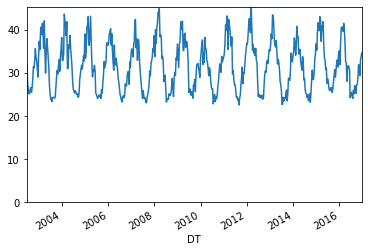

In [180]:
fig = plt.figure()


axes = plt.gca()
axes.set_ylim([0,oromia_df['LST'].max()])
oromia_df['LST'].plot()

# Random code

In [ ]:
#test = xr.merge([xr.open_rasterio(f) for f in ndvi_files[:4]])

In [ ]:
#get min and max value for image
for band in [ndvi_array1]:
    print("min {min} max {max}".format(min=band.min(), max=band.max()))

In [ ]:
#get value at top left corner
x_coord = ndvi02071.bounds.left
y_coord = ndvi02071.bounds.top

In [ ]:
#Stack tiffs


with rio.open(ndvi_files[0]) as src0:
    meta = src0.meta

meta.update(count=len(ndvi_files))

with rio.open('ndvi_stack.tiff', 'w', **meta) as dst:
    for id, layer in enumerate(ndvi_files, start=1):
        with rio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [ ]:
ndvi_concat =  xr.concat([xr.open_rasterio(f) for f in ndvi_files], dim = pd.Index([dekads], name = 'time'))

In [ ]:
fldas = os.listdir('/home/rgreen/tana-crunch/rgreen/DroughtEDM/Data/FLDAS/200207/')
dates = []
for filename in fldas:
    file = re.search(r'\d{4}.\d{3}', filename)
    dates.append(file.group())
    #print(file.group)

dates.sort()
print(dates)

In [ ]:
dates2 = pd.to_datetime(pd.Series(dates), format ='%Y%m%d')
pytesmo.timedate.dekad.check_dekad(dates2[1])
#s = pd.Series(['dates2'], name = "dates")
#df = pd.DataFrame('Dates':dates)

#df.insert(1, 'M', [str(x) for x in range (1,4) for i in range(10)])

#df

In [ ]:
n=10
final = [output[i * n:(i + 1) * n] for i in range((len(output) + n - 1) // n )]  
print (final)
len(final)

In [ ]:
test3 = np.mean(outputa[:(len(outputa)//10)*10].reshape(-1,10), axis=1)
test3

In [ ]:
data = pd.read_csv('TS_3887_421.csv.csv')
data.insert(2,'SM', dates)

In [ ]:
f = netCDF4.Dataset('/home/rgreen/tana-crunch/rgreen/DroughtEDM/Data/FLDAS/200207/LIS_HIST_200207010000.d01.nc')

print(f.variables.keys())

In [ ]:
allfiles = glob.glob('/home/rgreen/tana-crunch/rgreen/DroughtEDM/Data/FLDAS/200207/*.nc')

In [ ]:
#data200207 = xr.open_mfdataset('/home/rgreen/tana-crunch/rgreen/DroughtEDM/Data/FLDAS/200207/*.nc', concat_dim=[..., None, ...])

In [ ]:
data1 = '/home/rgreen/tana-crunch/rgreen/DroughtEDM/Data/FLDAS/200207/LIS_HIST_200207010000.d01.nc'
data2 = '/home/rgreen/tana-crunch/rgreen/DroughtEDM/Data/FLDAS/200207/LIS_HIST_200207020000.d01.nc'
data27 = '/home/rgreen/tana-crunch/rgreen/DroughtEDM/Data/FLDAS/FLDAS_NOAH01_C_GL_M.A200207.001.nc' #global monthly
DS1 = xr.open_dataset(data1)
DS2 = xr.open_dataset(data2)
DS27 = xr.open_dataset(data27)
DS1.SoilMoist_tavg[0,400:405,300:305]
#xidx = (np.abs(DS1.X - -17.83)).argmin()
#yidx = (np.abs(DS1.Y - long)).argmin()
DS1.Evap_tavg[1,0]

In [ ]:
DS1.SoilMoist_tavg[0,568,442]

In [ ]:
lat, lon = np.array(DS1.variables['Y'][:]), np.array(DS1.variables['X'][:])


In [ ]:
print(find_nearest(lat, 4))

In [ ]:
lat, lon = DS1.variables['Y'], DS1.variables['X']
latvals = lat[:]; lonvals = lon[:]

lat = np.array(DS1.variables['Y'][:])
sm = np.array(DS1.variables['SoilMoist_tavg'][0,:,:]) #change first value to indicate soil level, 0 = level 1
#iy_min, ix_min = getclosest_ij(latvals, lonvals, 4, 38)
lat.shape

In [ ]:
#iy_min, ix_min = getclosest_ij(latvals, lonvals, 4, 38)

dist_sq = (latvals - 4)**2 + (lonvals - 38)**2
idy, idx = np.where(dist_sq==dist_sq.min())
idy[0]
idx[0]

In [ ]:
i = np.abs(lonvals - 38).argmin()
j = np.abs(latvals -4).argmin()
DS1.SoilMoist_tavg[0,j,i]

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines() 
sm1.plot()
plt.show()

In [ ]:
sm1.cartopy_crs

In [ ]:
sm1_ras = rio.to_raster(sm1)

In [ ]:
sm_ras = rio.open('netcdf:/home/rgreen/tana-crunch/rgreen/DroughtEDM/Data/FLDAS/200207/LIS_HIST_200207010000.d01.nc:SoilMoist_tavg')

In [ ]:
#clip SM images to cropzones boundaries

with fiona.open('/home/rgreen/tana-crunch/rgreen/DroughtEDM/Data/cropzones/cropzones.shp', "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

src = rio.open('/home/rgreen/tana-crunch/rgreen/DroughtEDM/Data/eMODIS_NDVI/EastAfrica/data.2002.071_mask.tiff')

    
show((src,1))
ax = plt.gca()
patches = [PolygonPatch(feature, edgecolor="red", facecolor="none", linewidth=2) for feature in features]
ax.add_collection(mpl.collections.PatchCollection(patches, match_original=True))


In [ ]:
    #val = data.sample([x,y])
       #output = []
        
      #  for result in data.sample([(x, y)]): 
           # with openoutput.append(*((result-100)/100))
          # output =  ((result-100)/100)
       # return output
        
       # return result
            
            #output = (*((result-100)/100))
           # print
    
        #return return np.asarray(output)
        
        #np.asarray(output)
# with rio.open(tiff_dir + filename) as data:
         #   output.append(data.sample([(x, y)]))

In [ ]:
data = rio.open('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/CropsMask/data.2002.071_mask_crops.tiff')
for val in data.sample([(38.87, 4.21)]): print(val)


In [ ]:
class0=np.zeros((3,4))
class1=np.ones((3,4))
class2=np.ones((3,4))*2
class3=np.ones((3,4))*3
class_list=[class0,class1,class2,class3]
class_list

In [ ]:
class_list[1,0,0]

In [ ]:
lenlist=[x.shape[1,0,0] for x in class_list]
lenlist

In [ ]:
m = np.concatenate(class_list, axis=0)
m

In [ ]:
m[4]

### notes: 
Either need to aggregate by pixels, time series with all pixels or sample by pixels 


In [ ]:
crops = xr.open_dataset('/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/PCAM/pcam_mean_2014.nc')

In [ ]:
crops

In [ ]:
show(crops)